# Bayesian geolift with CausalPy

This notebook covers how to use `CausalPy`'s Bayesian synthetic control functionality to assess 'geolift'. Our hypothetical scenario is:

> We are a data scientist within a company that operates over Europe. We have been given a historical dataset of sales volumes, in units of 1000's. The data is broken down by country and was collected at weekly frequency. We have data for the past 4 years. 

> At the start of 2022, the marketing department decided to refurbish all the stores in Denmark. Now, at the end of 2022, the company wants you to assess whether this refurbishment programme increased sales. If you tell them that the store refurbishment scheme increased sales volumes then they will roll out the scheme to other countries. Nobody said this, but in the back of your mind you worry that if you tell them that refurbishments increase sales but that doesn't actually happen in the future, then the companies profits will drop, the value of your shares will decrease, and your job security may be at risk.

> Your boss is pretty tuned in. She also has these concerns. She knows that while it might be easy to establish an _association_ between the store refurbishments and changes in sales volumes, we really want to know if the store refurbishments _caused_ an increase in sales.

> We know that the best way to make causal claims is to run a randomized control trial (sometimes known as an [A/B test](https://en.wikipedia.org/wiki/A/B_testing)). If we have randomly assigned stores across Europe (or picked a country) at random, then perhaps an A/B test would do the job. But we did not pick Denmark at random - so we are worried about confounding variables.

> But we heard about synthetic control methods and a thing called GeoLift. After some research, we decide this is exactly what we want to do. But we are particularly interested in how certain we are in the level of any uplift we detect, so we want to use Bayesian methods and get easy to interpret Bayesian credible intervals. You find a library called `CausalPy` that supports exactly that use case and are delighted.

Let's go!

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option("display.precision", 2)

## Load the dataset

`CausalPy` includes an example (simulated) dataset suitable to explore ideas around geographical lift testing. All we need to do is to load that, get our observation dates set up appropriately in a pandas dataframe, and define the treatment time.

In [3]:
df = cp.load_data("geolift1")
# convert time column to datetime format
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
# define the treamtment time
treatment_time = pd.to_datetime("2022-01-01")
df.head()

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,Denmark
time,,,,,,,
2019-01-06,2.40,3.33,3.53,3.03,3.15,5.40,3.68
2019-01-13,2.41,3.22,3.50,2.96,3.14,5.19,3.40
2019-01-20,2.74,3.31,3.57,2.93,3.40,5.21,3.57
2019-01-27,2.70,3.36,3.43,2.94,3.43,5.10,3.64
2019-02-03,2.63,3.39,3.50,3.07,3.48,5.10,3.65


In our dataset, columns represent the different European countries that we operate in. We also have an index which labels each row with the date - the observations are weekly in frequency. The values in the table represent the sales volumes and are in units of 1000's. So a value of 2.4 represents 2,400 units sold per week.

So let's plot that.

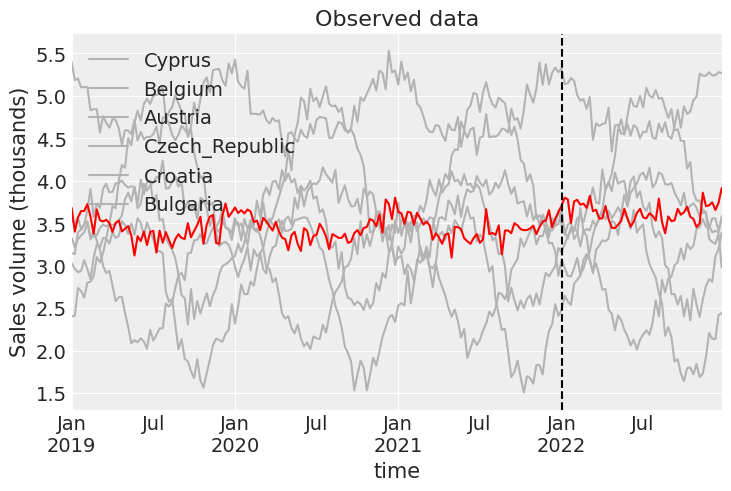

In [4]:
untreated = list(set(df.columns).difference({"Denmark"}))
ax = df[untreated].plot(color=[0.7, 0.7, 0.7])
df["Denmark"].plot(color="r", ax=ax)
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data", ylabel="Sales volume (thousands)");

This looks pretty nice, but also disappointing. It is not immediately obvious from a visual inspection that there is a clear change in sales data in Denmark after the stores were refurbished (shown by the dashed line). This is made worse by the presence of annual seasonality in the data (which is different in each country), and the inherent stochasticisty in the weekly sales data.

## Was there a geolift in sales in Denmark?

In order to calculate what (if any) causal effect there is from the store refurbishment we need to compare the _actual_ sales in Denmark after the intervention and the _counterfactual_ sales in Denmark if the intervention had not taken place. We can see why this is called the counterfactual - we _did_ refurbish the stores in Denmark, so this is a completely hypothetical scenario that runs _counter to the facts_. But if we could measure (or more realistically estimate) this, that would be our control group. 

In this case, we generate a synthetic control, which is the name of the technique we will be using to estimate our counterfactual sales data in Denmark if the refurbishment had not taken place. You can read more about the synthetic control method on the [synthetic control wikipedia page](https://en.wikipedia.org/wiki/Synthetic_control_method), but the basic idea is as follows. For those familiar with traditional (non-Bayesian) modelling methods, the basic synthetic control algorithm can be described like this:

```python
import my_custom_scikit_learn_model as weighted_combination


# fit the model to pre-intervention (training) data
weighted_combination.fit(X_train, y_train)
# estimate the counterfactual given post-intervention (test) data
counterfactual = weighted_combination.predict(X_test)
# estimate the causal impact
causal_impact = y_test - counterfactual
# cumulative causal impact
np.cumsum(causal_impact)
```

So there is no magic involved - we simply estimate a synthetic Denmark as a weighted sum of the untreated units. We do this based on the 'training' data observed before the intervention. We then use that weighted sum model to predict our synthetic Denmark based on 'test' data of untreated countries observed after the intervention. We can then simply compare this counterfactual estimate with the observed sales data in Denmark and obtain our estimate of the causal impact. We can then (optionally) calculate the cumulative causal impact to answer the question "How many more sales were caused by the store refurbishment over 2022?"

We can use `CausalPy`'s API to run this procedure, but using Bayesian inference methods as follows:

In [5]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="Denmark ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic",
    prediction_model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


We can see that our sampling went well. PyMC returns no sampling warnings, and we have no divergences. If we wanted to take a closer look to diagnose the sampling process we could do the following:

```python
az.summary(result.idata, round_to=2)
az.plot_trace(result.idata, var_names=["~mu"], compact=False);
```

## Results

Let's use Arviz examine the posterior parameter estimates for each of the beta weightings for each country, along with the estimate of the measurement standard deviation, `sigma`.

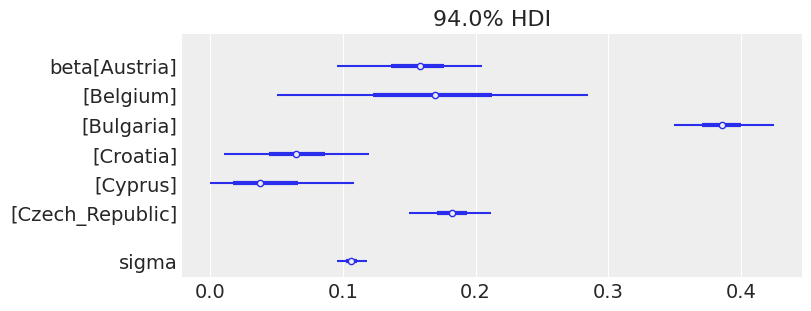

In [6]:
az.plot_forest(result.idata, var_names=["~mu"], figsize=(8, 3), combined=True);

If you are new to Bayesian methods, then I would recommend checking out these resources:

* The PyMC website [pymc.io](https://www.pymc.io), especially the examples page.
* There are also a whole bunch of video resources including:
  * [Chris Fonnesbeck - Probabilistic Python: An Introduction to Bayesian Modeling with PyMC](https://www.youtube.com/watch?v=911d4A1U0BE)
  * [Intro to Probabilistic Programming with PyMC (Austin Rochford)](https://www.youtube.com/watch?v=Qu6-_AnRCs8)
  * [The Bayesian Zig Zag: Developing and Testing PyMC Models (Allen Downey)](https://www.youtube.com/watch?v=EYS3oDhLsP0)
  * The [pymc-devs](https://www.youtube.com/@pymc-devs) YouTube channel.

We can now use the `plot` method of the `result` object that we get back from `CausalPy`. This will give us a pretty detailed visual output.

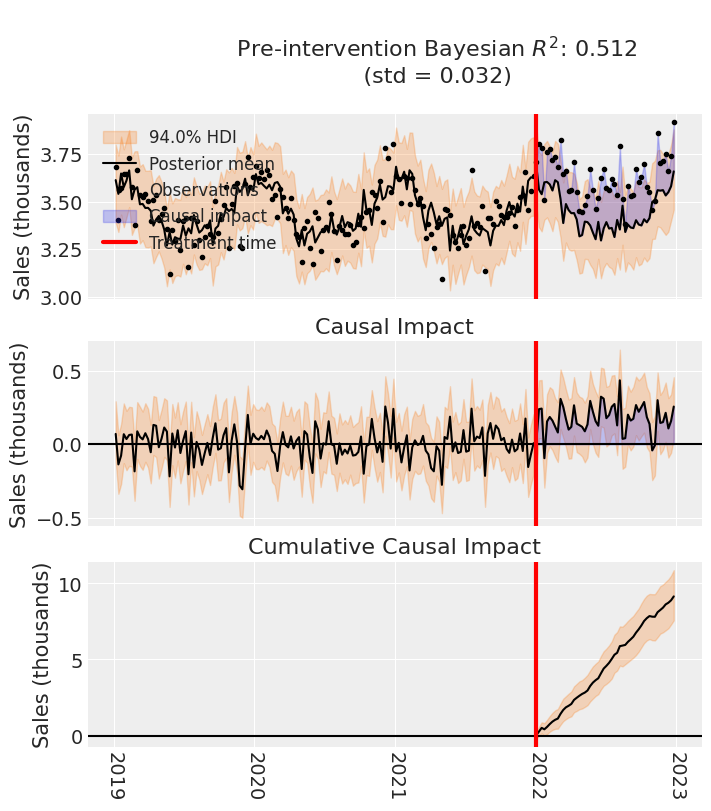

In [7]:
fig, ax = result.plot(plot_predictors=False)

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Sales (thousands)")

Nice! By creating a simple model formula and one call to `CausalPy`, we have been able to evaluate the lift generated in the treated unit.

In this example, there is quite a lot of measurement noise, but because we are using Bayesian inference methods here, we have a precise and principled quantification in our uncertainty.

We can see that the Bayesian $R^2$ value for the pre-treatment data is about 0.5. This is not excellent, but pretty good for real-world data. It shows that the linear weighted combination model (the core of synthetic control) is doing a reasonable job at constructing a faux (i.e. synthetic) Denmark up until the treatment period.

This synthetic control Denmark is our estimated counterfactual - what the sales would have been if the store renovation project had not been carried out. By looking at the difference we can estimate the causal impact, or we could also call it 'geographical lift'.

Over the year since implementation, we can see that the cumulative causal impact of sales in Denmark was close to 10,000 units. Let's examine that in more detail. Below we look at the posterior distribution of the cumulative causal impact at the end of our time series, after the scheme had been in place for 1 year.

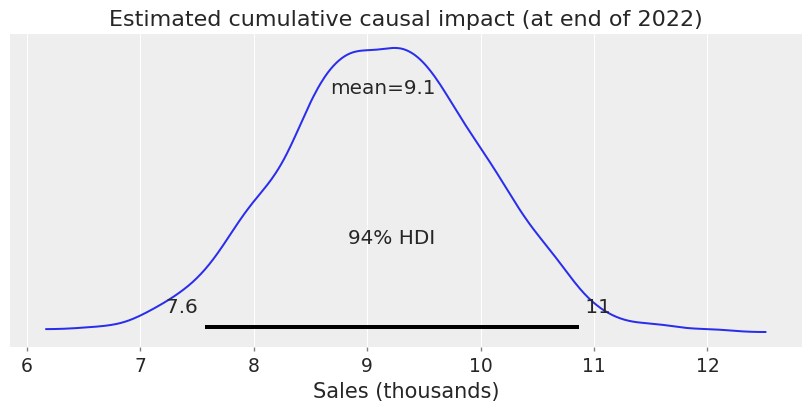

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
ax = az.plot_posterior(last_cumulative_estimate, figsize=(8, 4))
ax.set(
    title="Estimated cumulative causal impact (at end of 2022)",
    xlabel="Sales (thousands)",
);

If we want, we can also extract these statistics out numerically:

In [9]:
az.summary(last_cumulative_estimate, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,9.14,0.9,7.57,10.87


So at the end of our causal modelling endeavours we can report to our boss something along the lines of: "We believe that the store refurbishment scheme was causally responsible for driving a total of about 9140 additional sales. But we have uncertainty in the exact number of additional sales - our 94% credible regions span 7,570 to 10,870".

There are of course caveats worth bearing in mind. The analysis we've conducted has assumed that the only major event that might selectively influence sales in Denmark was the store renovation project. If this is a reasonable assumption then we may be on relatively stable ground in making causal claims. But if there were other events which selectively effected some units (countries) and not others, then we may need to be much more cautious in our claims and resort to more in-depth modelling approaches.

But our estimated cumulative causal impact of $9140^{10870}_{7570}$ is exactly the information needed by others in the company. They can use this figure (and even the uncertainty associated with it) and estimate how long it would take for the cost of renovating other stores to result in a net profit.

Your boss is very happy. You get a big end-of-year bonus.

## Beyond GeoLift
This example used geographical regions as the treatment units, but there is no _requirement_ for units to be geographical regions. For example, your units could be products. Maybe your company sells many different products and one (or a few of these) are chosen to be discounted. Did this intervention of discounting the price causally increase sales volumes? Synthetic control methods can answer this (and similar questions) just as easily.